In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
import snn_utils
from randman.randman import *
import matplotlib.pyplot as plt
import seaborn as sns
from randman_utils import *

In [2]:
from LIFlayer import OneHiddenModel,FiveHiddenModel,OneRecHiddenModel

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [4]:


def train_test(data,test_frac=.2):
    train = data[:int(len(data)*(1-test_frac))]
    test = data[int(len(data)*(1-test_frac)):]
    return train,test

def get_X_y(data,labels,T):
    X_train, X_test = train_test(data)
    y_train, y_test = train_test(labels)
    X_train = prep_data(X_train,T=T)
    X_test = prep_data(X_test, T=T)
    y_train = prep_labels(y_train)
    y_test = prep_labels(y_test)
    return X_train, X_test, y_train,y_test

def create_data(N,T,batch_size,nb_classes,nb_samples,alpha,device='cpu'):
    data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=nb_samples,shuffle=True,alpha=alpha)
    show_samples(data,labels)
    data = torch.IntTensor(data)
    X_train, X_test, y_train, y_test = get_X_y(data,labels,T)
    train_batch_ids = get_batches(X_train,batch_size)
    test_batch_ids = get_batches(X_test,batch_size)
    y_train = y_train.long()
    y_test = y_test.long()
    return torch.tensor(X_train,device=device),torch.tensor(X_test,device=device),torch.tensor(y_train,device=device),torch.tensor(y_test,device=device),torch.tensor(train_batch_ids,device=device),torch.tensor(test_batch_ids,device=device)

In [5]:
def get_Ws(N,nb_classes,epsilon=.5,base_w = 1,w = 1,plot=True,device=device):
    n_assemblies = nb_classes
    ss = StandardScaler()
    mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=1.)
    mask = (mask* (base_w*w)) + base_w

    W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
    if w > 0.:
        W *= base_w
        W *= mask

    if epsilon ==1:
        W = W-1
    W2 = (W != 0).astype(int)
    if plot:
        plt.title('W')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
        plt.title('W2')
        plt.imshow(W2)
        plt.colorbar()
        plt.show()
    return torch.tensor(W,device=device,dtype=torch.float32), torch.tensor(W2,device=device,dtype=torch.float32)

In [6]:
def validation_acc(X_test,y_test,model,test_batch_ids):
    sum_acc = 0
    decay=.9
    count = 0
    for i in range(len(test_batch_ids)):
        model.eval()
        model.init_states()

        out = torch.zeros((batch_size,model.out_channels),device=device)
        out_rec = [out]
        count +=1
        for n in range(T):

            out_state = model(X_test[test_batch_ids[i],n])
            out_rec.append(out_state.U)


        out_rec = torch.stack(out_rec,dim=1)
        prediction = torch.max(out_rec,1).values

        accuracy = val_accuracy(prediction,y_test[test_batch_ids[i]])
        sum_acc = sum_acc + accuracy
    avg_acc = sum_acc/count
    return avg_acc,prediction,y_test[test_batch_ids[i]]

def val_accuracy(prediction,y):

    return (y == prediction.argmax(axis=1)).sum()/len(prediction)

In [7]:
def train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W,W2,lr,decay,epochs=100,use_W=False,use_W2=False,print_each=5,device='cpu'):
    in_channels=N
    hidden_channels = N
    out_channels = nb_classes
    #model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

    #mse_loss = torch.nn.MSELoss()
    ce_loss = torch.nn.CrossEntropyLoss()

    #apply W
    if use_W:
        model.init_mod_weights(W)

    #layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
    params = model.parameters()
    opt = torch.optim.Adam(params, lr=lr, betas=[0., .95]) #lr is the learning rate
    loss_hist = []
    acc_hist = []
    #epochs
    for e in range(epochs):
        batch_loss = 0
        batch_acc=0
        model.train()

        #batches

        #if e%10 == 0:
        #    y = model.layer1.fc_layer.weight.clone().detach()
        #    plt.imshow(y)
        #    plt.show()
        #plt.imshow(W)
        #plt.show()
        for i in range(len(train_batch_ids)):

            model.init_states()

            out = torch.zeros((batch_size,model.out_channels),device=device)
            out_rec = [out]
        #timesteps
            for n in range(T):
                out_state = model(X_train[train_batch_ids[i],n])

            #add decay for leakiness
            #collect spikes over time
                out_rec.append(out_state.U)

            out_rec = torch.stack(out_rec,dim=1)
            prediction = torch.max(out_rec,1).values
            accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])
            loss = ce_loss(prediction,y_train[train_batch_ids[i]])

            loss.backward()
            opt.step()
            opt.zero_grad()
            if use_W2:
                model.init_mod_weights(W2)
            batch_acc = batch_acc + accuracy
            batch_loss = batch_loss + loss
        epoch_acc = batch_acc/(len(train_batch_ids))
        epoch_loss = batch_loss/(len(train_batch_ids))
        loss_hist = loss_hist + [float(epoch_loss)]
        acc_hist = acc_hist + [float(epoch_acc)]


        if e%print_each==0:
            print(f'epoch {e}: \n loss: {epoch_loss}')
            print(f'train_acc: {epoch_acc}')
    return loss_hist,acc_hist

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


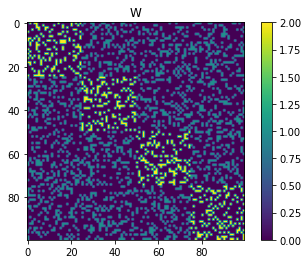

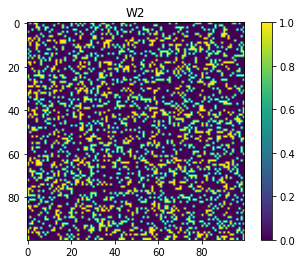

created 80 batches
created 20 batches


/tmp/ipykernel_1868815/574499634.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X_train,device=device),torch.tensor(X_test,device=device),torch.tensor(y_train,device=device),torch.tensor(y_test,device=device),torch.tensor(train_batch_ids,device=device),torch.tensor(test_batch_ids,device=device)


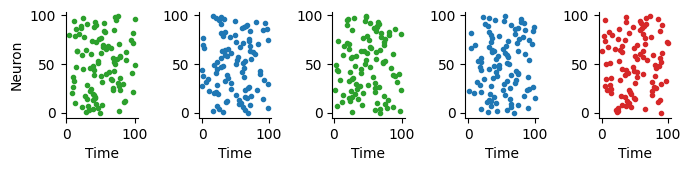

In [9]:
N=100
T=100
batch_size=40
nb_classes=4
W,W2 = get_Ws(N=N,nb_classes=nb_classes,epsilon=.25,device=device)

X_train,X_test,y_train, y_test, train_batch_ids,test_batch_ids =create_data(N=N,T=T,batch_size=batch_size,nb_classes=nb_classes,nb_samples=1000,alpha=1.5,device=device)
model = OneRecHiddenModel(in_channels=N,hidden_channels=N,out_channels=nb_classes,batch_size=batch_size,device=device)

In [10]:
loss, acc = train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W=W,W2=W2,lr=1e-4,decay=.9,use_W=True,use_W2=True,print_each=5,epochs=10,device=device)

epoch 0: 
 loss: 1.3886425495147705
train_acc: 0.24250002205371857
epoch 5: 
 loss: 1.238119125366211
train_acc: 0.41124996542930603


In [11]:
model.layer2.fc_layer.weight.data.device

device(type='cuda', index=0)

In [12]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
#val_acc_hist = val_acc_hist + [val_acc]
print(f'val_acc: {val_acc}')

val_acc: 0.5637499690055847


torch.Size([800, 100, 100])

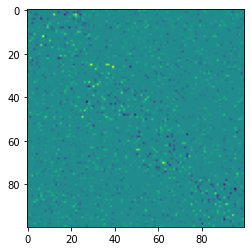

In [12]:
plt.imshow(model.layer3.fc_layer.weight.data)